## Artificial Intelligence for Cybersecurity Project
### Dataset used: [Malicious URLs dataset by Manu Siddhartha](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)

### Candidates: Riccardo Fantasia & Leonardo Pantani

In [1]:
# tolgo i warning dalle print
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importo il dataset grezzo
import pandas as pd
df_raw = pd.read_csv("UNIPI-IA-dataset.csv")

In [3]:
# definiamo i tipi in uno specifico ordine. Questo serve perché in caso di duplicati, per esempio:
# https://www.sito-strano.com/haivintounpremio - malware
# https://www.sito-strano.com/haivintounpremio - benign
#
# rimuoveremmo tutti i sample, tranne il primo. Si è deciso questo perché, in questo contesto,
# è preferibile avere un Falso Positivo (FP), manualmente "correggibile" dall'utente, che un Falso Negativo (FN),
# che potrebbe esporrebbe l'utente ad un sito malevolo.

types = ["malware", "phishing", "defacement", "benign"]

df_raw["type"] = pd.Categorical(df_raw["type"], categories=types, ordered=True)
df = df_raw.sort_values(by="type").drop_duplicates(subset="url", keep="first")

print(f"Sample nel Dataset originale: {df_raw.shape[0]}\nSample nel Dataset senza duplicati: {df.shape[0]} (riduzione del {((df_raw.shape[0] - df.shape[0]) / df_raw.shape[0]) * 100:.2f}%)")


Sample nel Dataset originale: 651191
Sample nel Dataset senza duplicati: 641119 (riduzione del 1.55%)


In [4]:
# mostra per ogni classe il numero di url nel dataset
from plotly import graph_objects as go

total_count = df['type'].shape[0]
count = df['type'].value_counts()
percentages = (count / total_count * 100).round(2)
colors = ['#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6', '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D']

fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors), text=[f"{p}%" for p in percentages], textposition='outside', textfont=dict(color='white'))])
fig.update_layout(xaxis_title='Etichette', yaxis_title='n° di URL', title='Conteggio per differenti etichette', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [5]:
# estriamo 23 feature
from utils.features_extractors import (extract_feature_ip_use,extract_feature_url_entropy,extract_feature_num_digits,extract_feature_url_length,extract_feature_num_query_parameters,extract_feature_num_fragments,extract_feature_num_percent20,extract_feature_num_at_signs,extract_feature_has_http,extract_feature_has_https,extract_feature_dot_number,extract_feature_num_www, extract_feature_directory_num,extract_feature_embed_domain_number,extract_feature_suspiciousurl,extract_feature_count_percent,extract_feature_count_dash,extract_feature_count_equal,extract_feature_is_shortened,extract_feature_hostname_length,extract_feature_first_directory_length,extract_feature_top_level_domain_length,extract_feature_num_letters)

df['ip_use'] = df['url'].apply(extract_feature_ip_use)
df['url_entropy'] = df['url'].apply(extract_feature_url_entropy)
df['num_digits'] = df['url'].apply(extract_feature_num_digits)
df['url_length'] = df['url'].apply(extract_feature_url_length)
df['num_query_parameters'] = df['url'].apply(extract_feature_num_query_parameters)
df['num_fragments'] = df['url'].apply(extract_feature_num_fragments)
df['num_percent20'] = df['url'].apply(extract_feature_num_percent20)
df['num_at_signs'] = df['url'].apply(extract_feature_num_at_signs)
df['has_http'] = df['url'].apply(extract_feature_has_http)
df['has_https'] = df['url'].apply(extract_feature_has_https)
df['dot_number'] = df['url'].apply(extract_feature_dot_number)
df['num_www'] = df['url'].apply(extract_feature_num_www)
df['directory_num'] = df['url'].apply(extract_feature_directory_num)
df['embed_domain_number'] = df['url'].apply(extract_feature_embed_domain_number)
df['suspiciousurl'] = df['url'].apply(extract_feature_suspiciousurl)
df['count_percent'] = df['url'].apply(extract_feature_count_percent)
df['count_dash'] = df['url'].apply(extract_feature_count_dash)
df['count_equal'] = df['url'].apply(extract_feature_count_equal)
df['is_shortened'] = df['url'].apply(extract_feature_is_shortened)
df['hostname_length'] = df['url'].apply(extract_feature_hostname_length)
df['first_directory_length'] = df['url'].apply(extract_feature_first_directory_length)
df['top_level_domain_length'] = df['url'].apply(extract_feature_top_level_domain_length)
df['num_letters'] = df['url'].apply(extract_feature_num_letters)

print(f"Numero di feature totale: { df.drop(columns=['type', 'url']).shape[1] }")

Numero di feature totale: 23


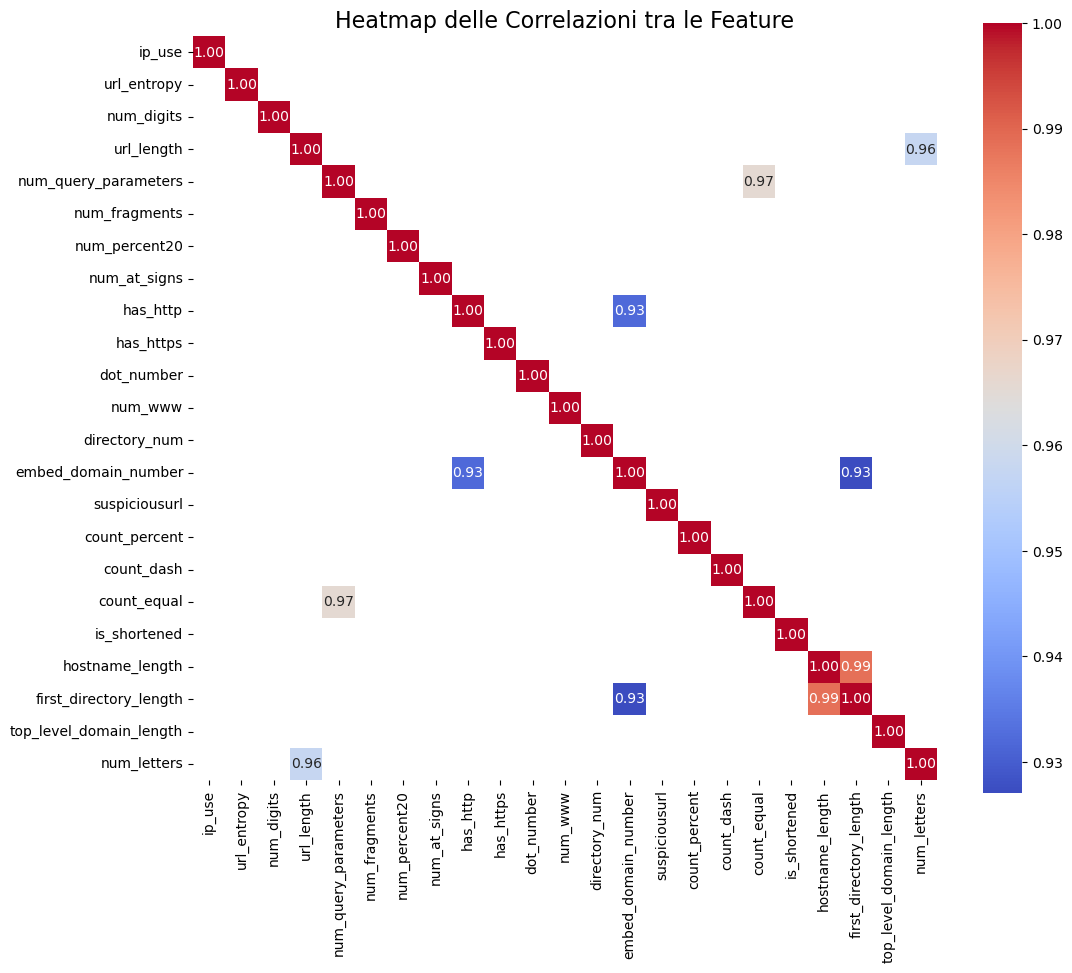

In [6]:
# mostro una heatmap delle feature

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

correlation_matrix = df.drop(columns=['type', 'url']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, mask = (np.abs(correlation_matrix) <= 0.9))
plt.title("Heatmap delle Correlazioni tra le Feature", fontsize=16)
plt.show()

In [7]:
# rimuoveremo, data la heatmap, le feature con una correlazione >= 0.9. Lista:
# embed_domain_number, count_equal, url_length, first_directory_length
df = df.drop(columns=["embed_domain_number", "count_equal", "url_length", "first_directory_length"])

In [8]:
# Creiamo ora per i nostri scopi successivi una funzione per ripulire il dataset da alcuni outlier.
# Decidiamo di impostare un treshold abbastanza conservativo (3xIQR) data la natura dei numerevoli outlier, che non derivano da errori di misura, 
# ma rappresentano possibili URL malevoli o casi limite. Rimuoverli in modo troppo aggressivo (1.5xIQR) rischierebbe di perdere esempi rilevanti per il modello.
# La soglia più ampia massimizza la conservazione di dati potenzialmente informativi pur riducendo valori estremi eccessivi.
def remove_outliers(df):
    df_clean = df.copy()
    columns=['url_entropy', 'num_digits', 'dot_number', 'directory_num', 'hostname_length', 'top_level_domain_length', 'num_letters']
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & 
            (df_clean[column] <= upper_bound)
        ]
    return df_clean

In [13]:
# dividiamo il dataset in training set (80%) e in test set (20%)
from sklearn.model_selection import train_test_split
from utils.utils import printInfo

train_ratio = 0.80
test_ratio = 0.20
x_train_unbalanced, x_test, y_train, y_test = train_test_split(df.drop(columns=["type", "url"]).copy(), df["type"].copy(), test_size=1-train_ratio, shuffle=True, stratify=df["type"].copy())

print("Distribuzione delle classi del dataset di training con outliers")
printInfo("training", y_train)

Distribuzione delle classi del dataset di training con outliers
Esempi di training [tot: 512895]:
 Classe defacement: 76246 (14.87% del totale)
 Classe benign: 342459 (66.77% del totale)
 Classe phishing: 75274 (14.68% del totale)
 Classe malware: 18916 (3.69% del totale)


In [14]:
# rimuovo gli outliers da training set
x_train_clean_unbalanced = remove_outliers(x_train_unbalanced)
y_train_clean = y_train[x_train_clean_unbalanced.index]

print("Distribuzione delle classi del dataset di training senza outliers")
printInfo("training", y_train_clean)
print(f"Riduzione del dataset di training di {x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]} elementi (riduzione del {((x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]) / x_train_unbalanced.shape[0]) * 100:.2f}%)")

Distribuzione delle classi del dataset di training senza outliers
Esempi di training [tot: 487376]:
 Classe defacement: 72943 (14.97% del totale)
 Classe benign: 326982 (67.09% del totale)
 Classe phishing: 71623 (14.70% del totale)
 Classe malware: 15828 (3.25% del totale)
Riduzione del dataset di training di 25519 elementi (riduzione del 4.98%)


In [15]:
# stampa distribuzione delle classi test set
print("Distribuzione delle classi del dataset di test") 
printInfo("test", y_test)

Distribuzione delle classi del dataset di test
Esempi di test [tot: 128224]:
 Classe benign: 85615 (66.77% del totale)
 Classe defacement: 19062 (14.87% del totale)
 Classe phishing: 18818 (14.68% del totale)
 Classe malware: 4729 (3.69% del totale)


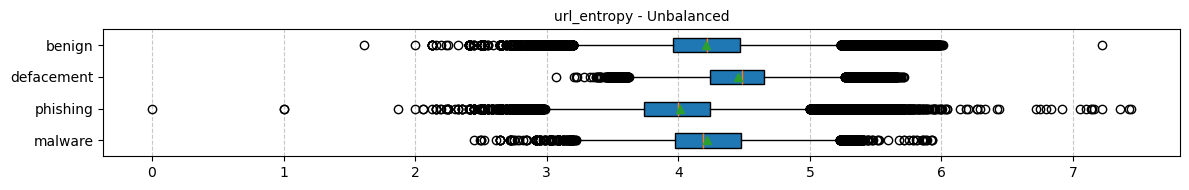

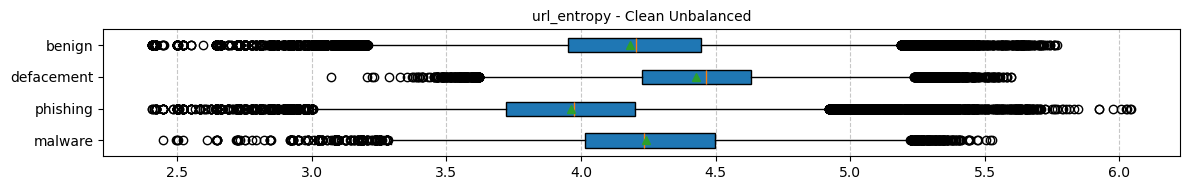

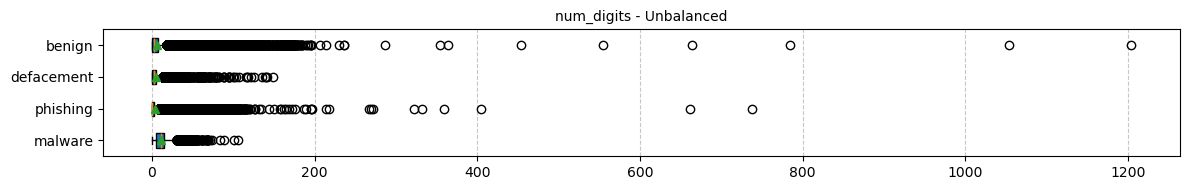

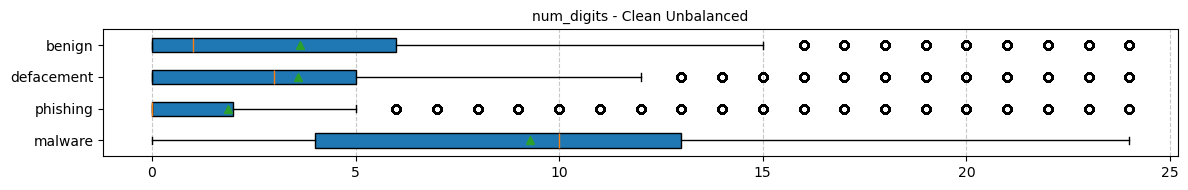

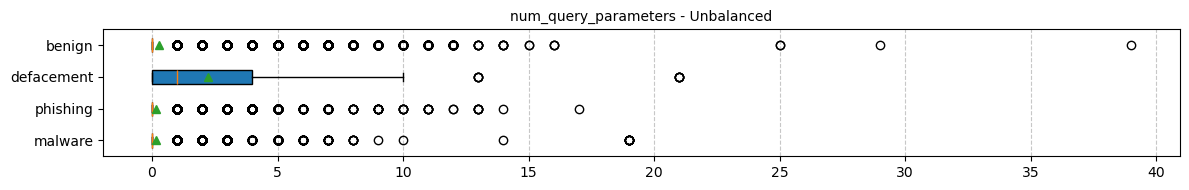

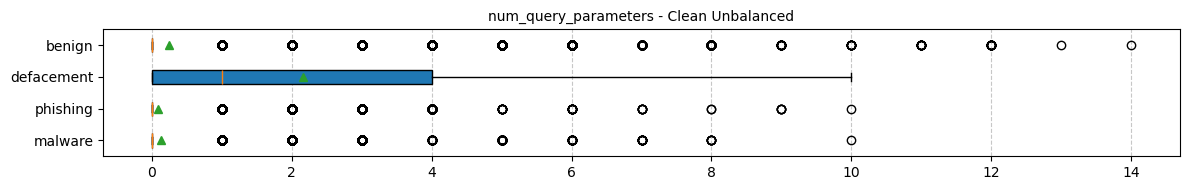

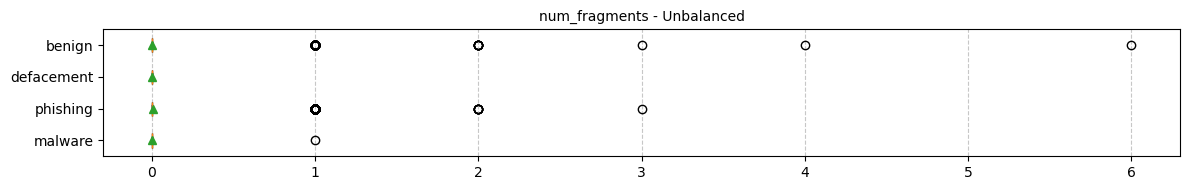

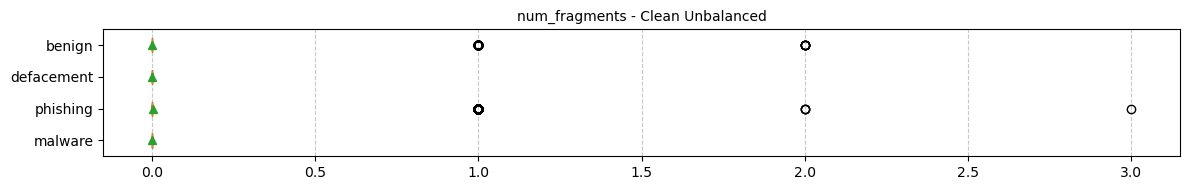

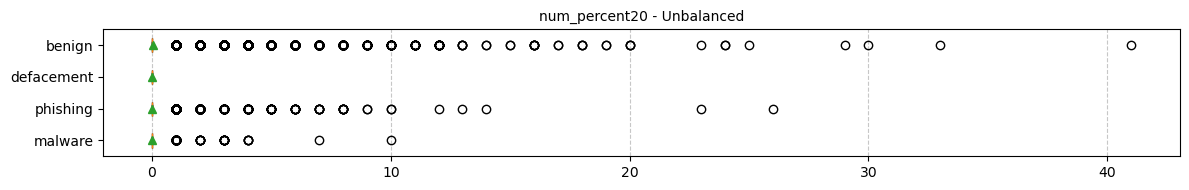

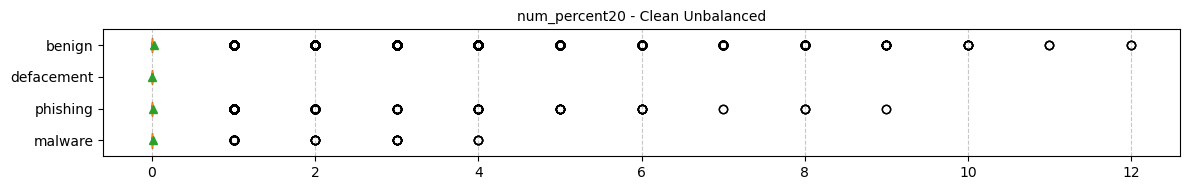

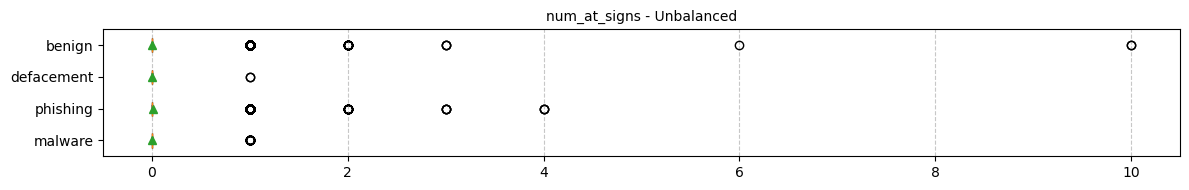

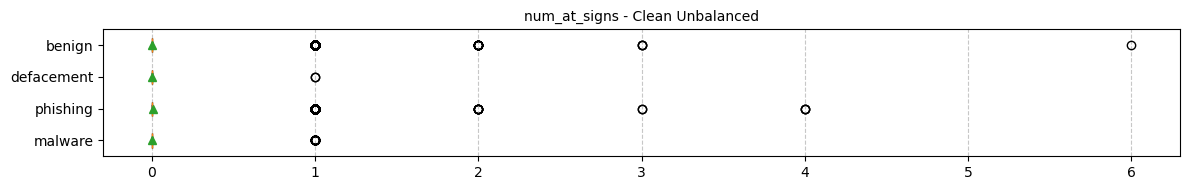

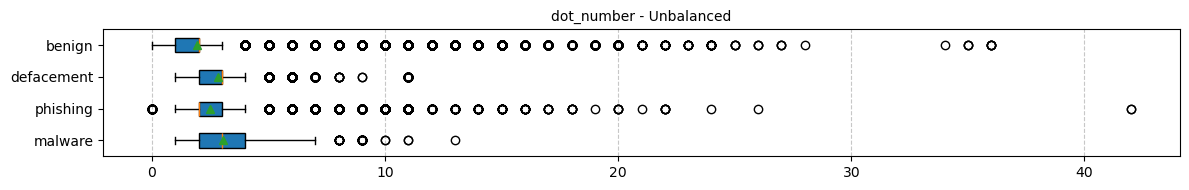

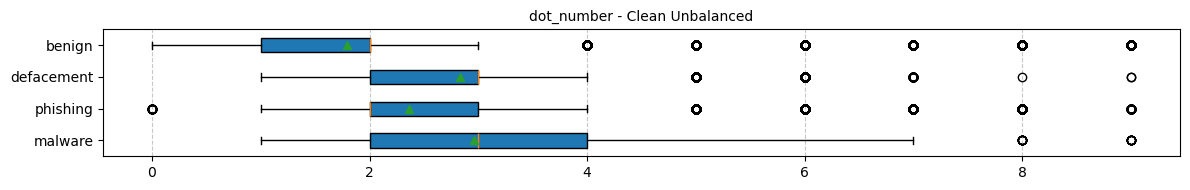

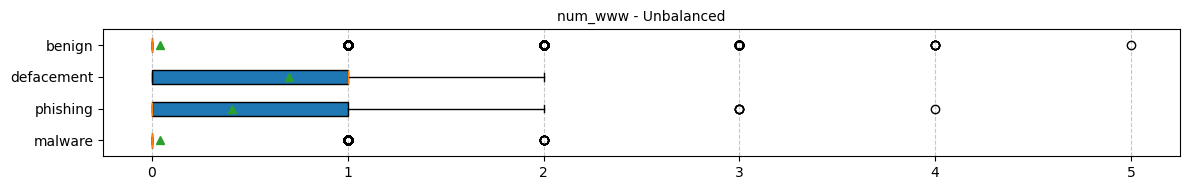

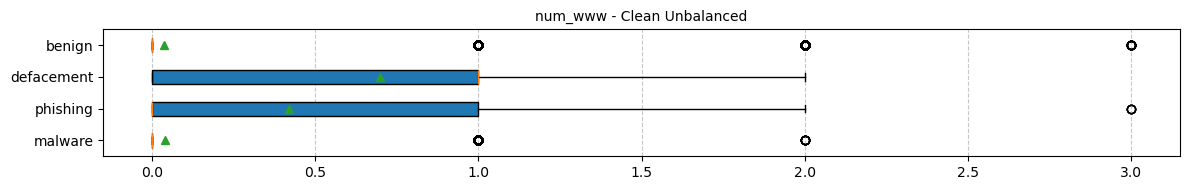

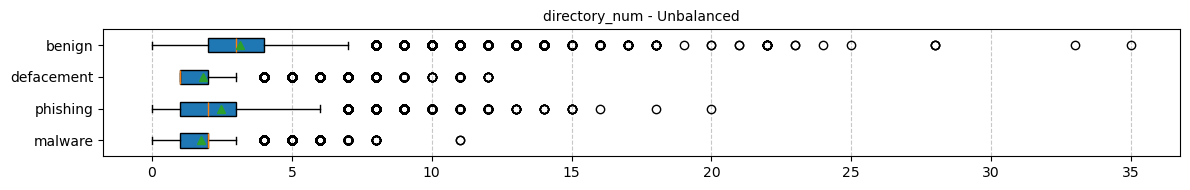

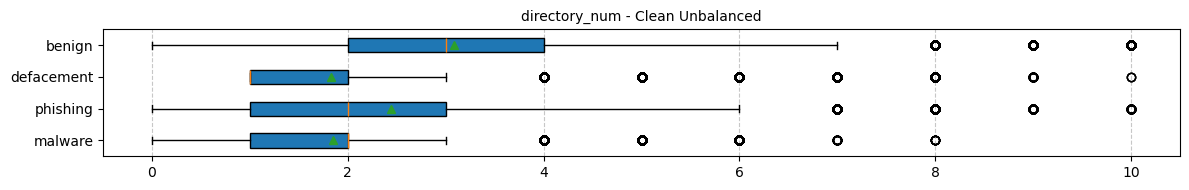

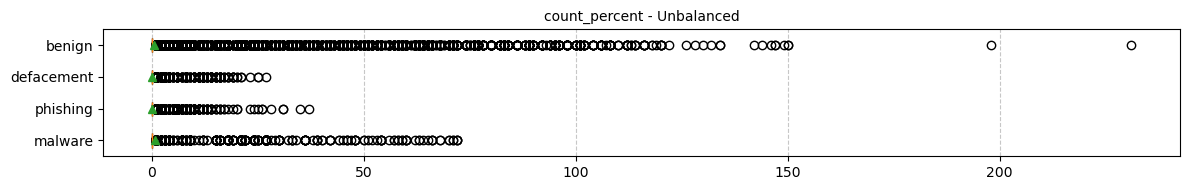

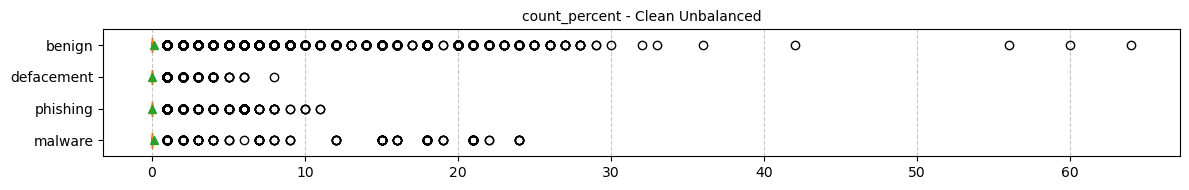

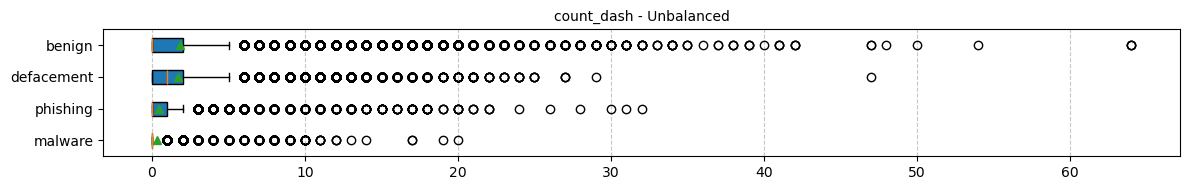

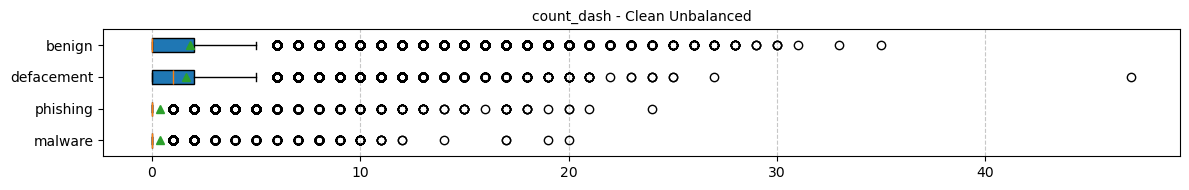

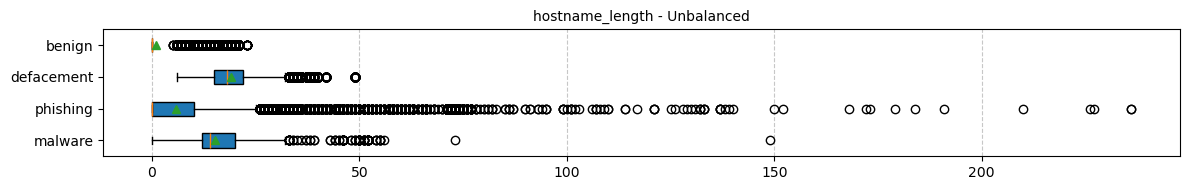

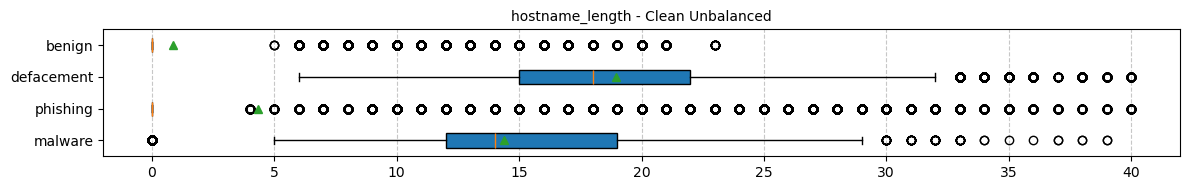

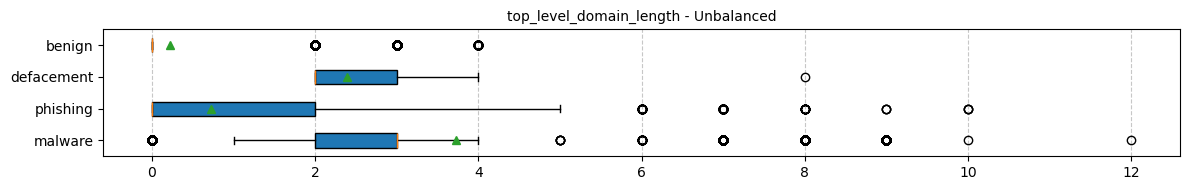

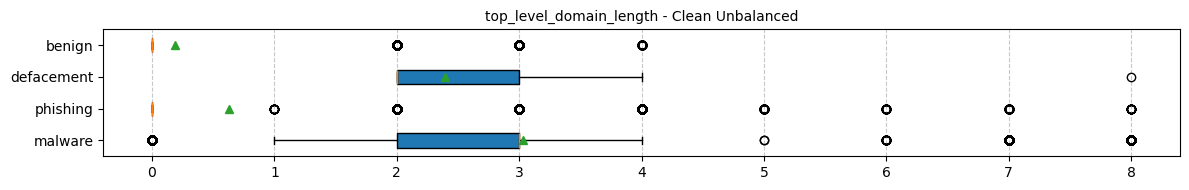

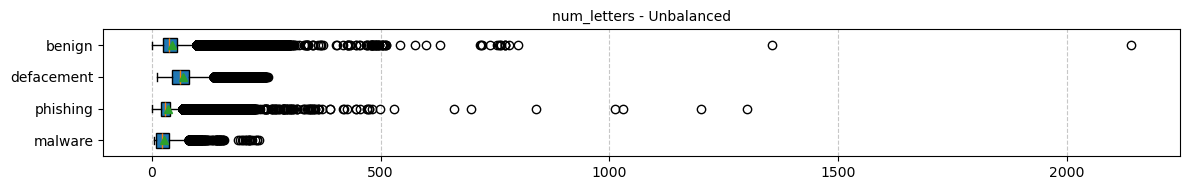

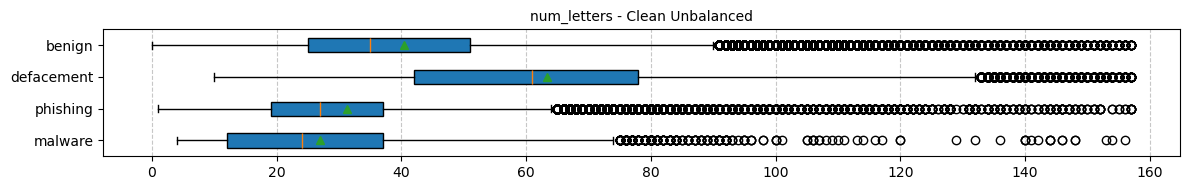

In [21]:
import matplotlib.pyplot as plt

features = ['url_entropy', 'num_digits', 'num_query_parameters', 'num_fragments', 'num_percent20', 'num_at_signs', 'dot_number', 'num_www', 'directory_num', 'count_percent', 'count_dash', 'hostname_length', 'top_level_domain_length', 'num_letters']
classes = df["type"].unique()

def plot_feature_analysis(features, classes, x_train_unbalanced, y_train, x_train_clean_unbalanced, y_train_clean):
    # Analisi delle feature continue
    for feature in features:
        plt.figure(figsize=(12, 2))
        
        # Primo boxplot con x_train_unbalanced e y_train
        data = [x_train_unbalanced[y_train == class_label][feature].dropna() for class_label in classes]
        plt.boxplot(data, vert=False, patch_artist=True, showmeans=True, labels=classes)
        plt.title(f'{feature} - Unbalanced', fontsize=10)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Secondo boxplot con x_train_clean_unbalanced e y_train_clean
        plt.figure(figsize=(12, 2))
        data_clean = [x_train_clean_unbalanced[y_train_clean == class_label][feature].dropna() for class_label in classes]
        plt.boxplot(data_clean, vert=False, patch_artist=True, showmeans=True, labels=classes)
        plt.title(f'{feature} - Clean Unbalanced', fontsize=10)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_feature_analysis(features, classes, x_train_unbalanced, y_train, x_train_clean_unbalanced, y_train_clean)

In [25]:
# un aspetto che notiamo dall'output soprastante è lo sbilanciamento, in termini di numero di sample, della classe malevola rispetto alla benigna.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

def balance_data_undersample_benign(x_train, y_train):
    class_counts = Counter(y_train)
    other_classes_count = sum([class_counts[label] for label in class_counts if label != "benign"])
    benign_target = other_classes_count
    undersampling_strategy = {"benign": benign_target}
    rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)
    return x_train_resampled, y_train_resampled

x_train, y_train = balance_data_undersample_benign(x_train_unbalanced, y_train)
x_train_clean, y_train_clean = balance_data_undersample_benign(x_train_clean_unbalanced, y_train_clean) # senza outliers
printInfo("training bilanciato", y_train)
print()
printInfo("training pulito bilanciato", y_train_clean)

Esempi di training bilanciato [tot: 340872]:
 Classe benign: 170436 (50.00% del totale)
 Classe defacement: 76246 (22.37% del totale)
 Classe malware: 18916 (5.55% del totale)
 Classe phishing: 75274 (22.08% del totale)

Esempi di training pulito bilanciato [tot: 320788]:
 Classe benign: 160394 (50.00% del totale)
 Classe defacement: 72943 (22.74% del totale)
 Classe malware: 15828 (4.93% del totale)
 Classe phishing: 71623 (22.33% del totale)


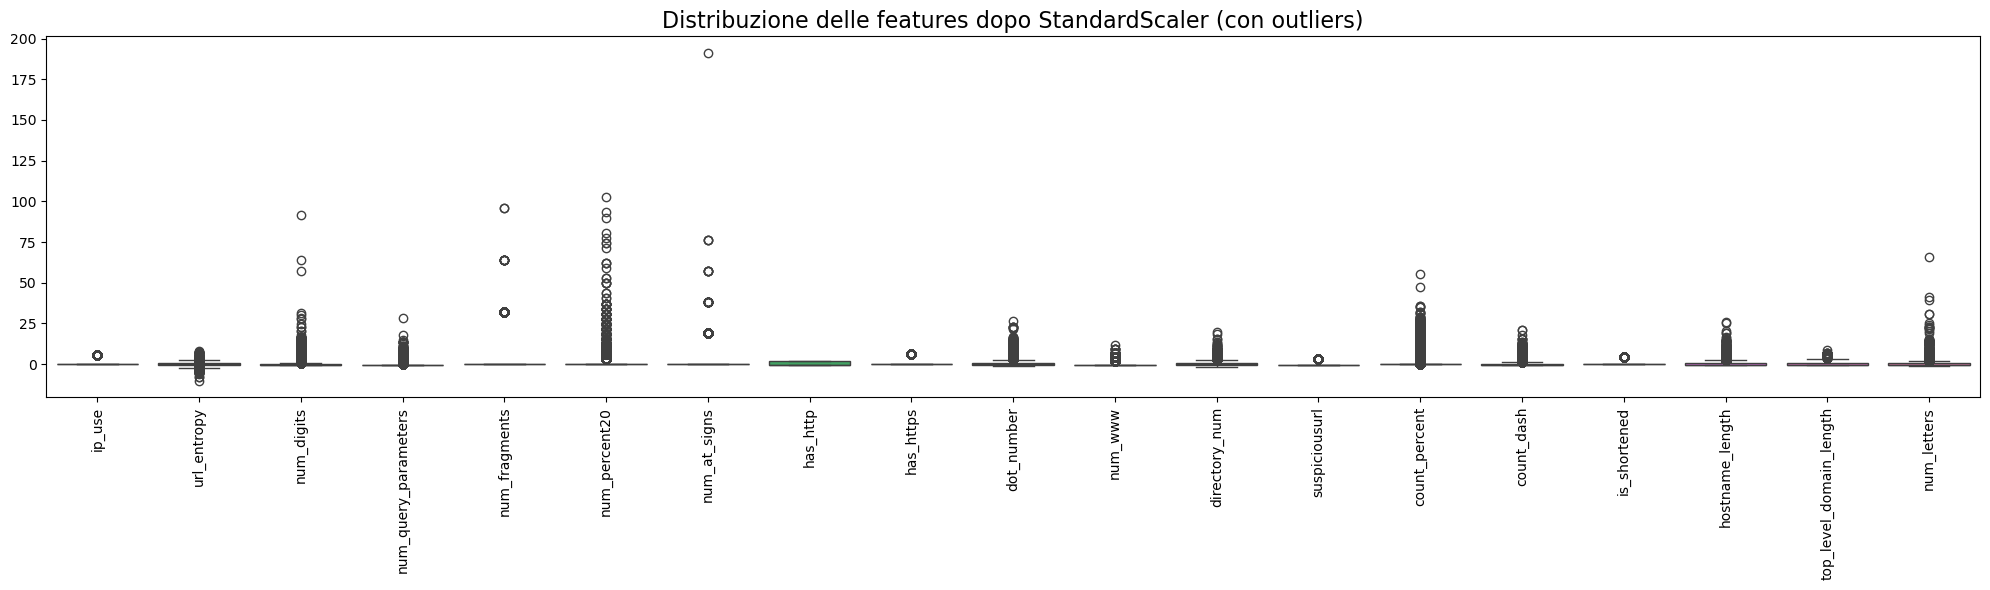

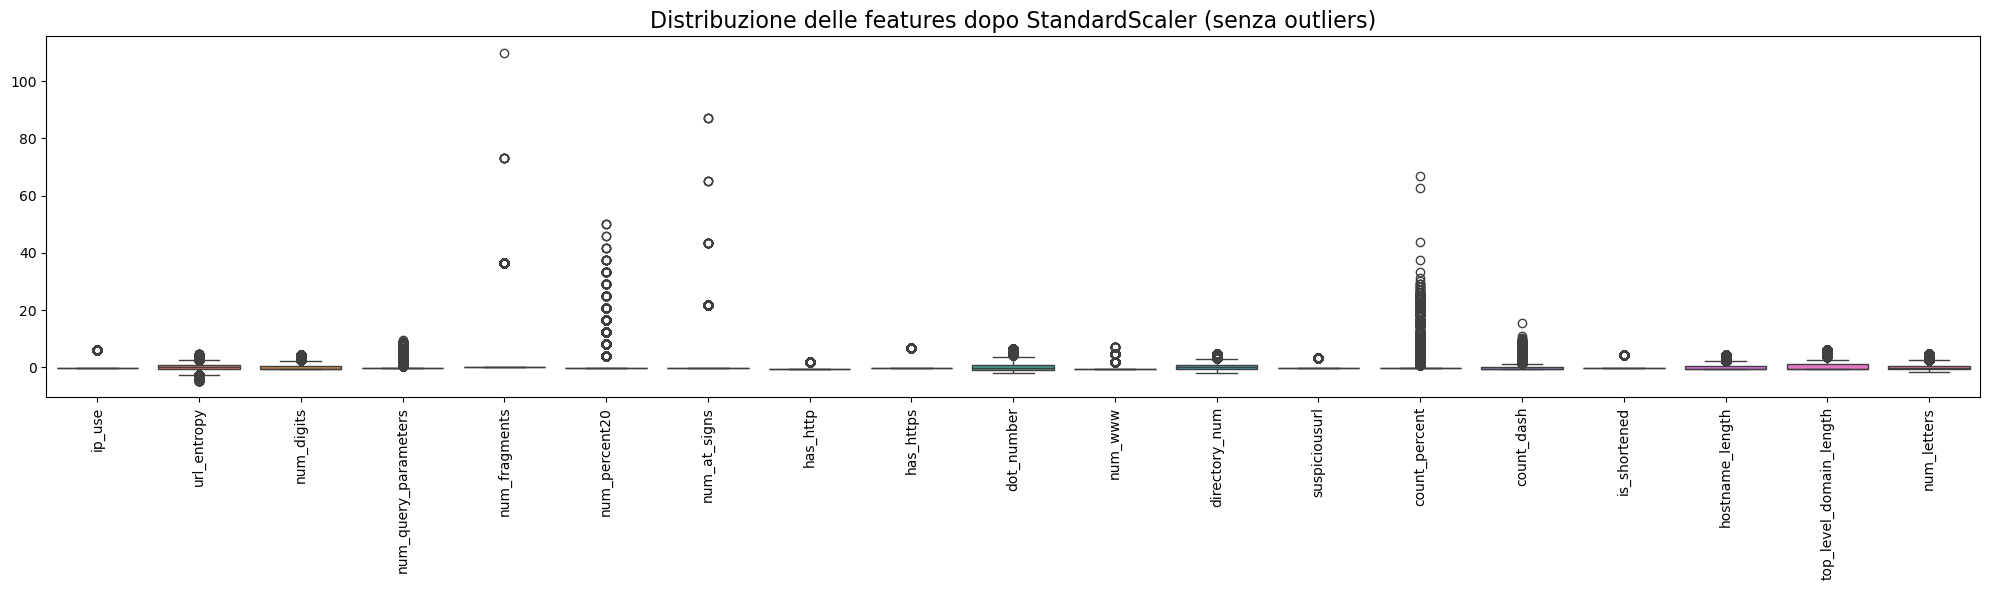

In [28]:
# Nell'ottica di una classificazione eseguita mantenendo gli outliers, si procede inizialmente con una normalizzazione StandardScaler che mantiene meglio l'effetto degli outliers.
# Dopodiché si procederà con una Z-Normalization.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# dati con outliers
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)


# dati senza outliers
x_train_clean_scaled = scaler.fit_transform(x_train_clean)

x_train_clean_scaled = pd.DataFrame(x_train_clean_scaled, columns=x_train_clean.columns, index=x_train_clean.index)



# Visualizzazione con boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(data=x_train_scaled)
plt.title('Distribuzione delle features dopo StandardScaler (con outliers)', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(data=x_train_clean_scaled)
plt.title('Distribuzione delle features dopo StandardScaler (senza outliers)', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_randomforest = RandomForestClassifier()
classifier_randomforest.fit(x_train, y_train)